In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
%matplotlib inline

In [222]:
seq_len = 30
d = 0.1
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 100

**Use 3 years of sp500 data**

In [173]:
df = pd.read_csv('D:/data/sp500.csv', index_col = 'Date')
df.drop(['Volume', 'Close'], 1, inplace = True)
df.index = pd.to_datetime(df.index)
df.head()

,Open,High,Low,Adj Close
Date,,,,
2013-05-17,1652.449951,1667.469971,1652.449951,1667.469971
2013-05-20,1665.709961,1672.839966,1663.520020,1666.290039
2013-05-21,1666.199951,1674.930054,1662.670044,1669.160034
2013-05-22,1669.390015,1687.180054,1648.859985,1655.349976
2013-05-23,1651.619995,1655.500000,1635.530029,1650.510010


In [174]:
min_max_scaler = preprocessing.MinMaxScaler()
df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
df['Adj Close']=min_max_scaler.fit_transform(
    df['Adj Close'].values.reshape(-1,1))

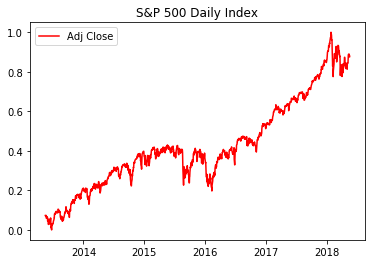

,Open,High,Low,Adj Close
Date,,,,
2013-05-17,0.058098,0.061288,0.071347,0.072612
2013-05-20,0.068380,0.065470,0.079921,0.071704
2013-05-21,0.068760,0.067098,0.079263,0.073913
2013-05-22,0.071233,0.076637,0.068567,0.063288
2013-05-23,0.057455,0.051966,0.058243,0.059564


In [175]:
plt.plot(df['Adj Close'], color = 'red', label = 'Adj Close')
plt.legend(loc = 'best')
plt.title('S&P 500 Daily Index')
plt.show()
df.head()

In [133]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 8weeks
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]
    #return train

In [223]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [224]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(1107, 30, 4)

In [225]:
y_train.shape[0]

1107

In [213]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], 
                   input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1],
                   input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],
                    kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],
                         kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer= adam, metrics=['accuracy'])
    model.summary()
    return model

In [226]:
model = build_model2(shape, neurons, d)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 30, 128)           68096     
_________________________________________________________________
dropout_23 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [227]:
model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=300,
    validation_split=0.1,
    verbose=2)

Train on 996 samples, validate on 111 samples
Epoch 1/300
 - 5s - loss: 0.1235 - acc: 0.0000e+00 - val_loss: 0.3480 - val_acc: 0.0000e+00
Epoch 2/300
 - 2s - loss: 0.0536 - acc: 0.0000e+00 - val_loss: 0.1220 - val_acc: 0.0000e+00
Epoch 3/300
 - 2s - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.0494 - val_acc: 0.0000e+00
Epoch 4/300
 - 2s - loss: 0.0133 - acc: 0.0000e+00 - val_loss: 0.0751 - val_acc: 0.0000e+00
Epoch 5/300
 - 2s - loss: 0.0084 - acc: 0.0000e+00 - val_loss: 0.0945 - val_acc: 0.0000e+00
Epoch 6/300
 - 2s - loss: 0.0083 - acc: 0.0000e+00 - val_loss: 0.0879 - val_acc: 0.0000e+00
Epoch 7/300
 - 2s - loss: 0.0069 - acc: 0.0000e+00 - val_loss: 0.0715 - val_acc: 0.0000e+00
Epoch 8/300
 - 2s - loss: 0.0059 - acc: 0.0000e+00 - val_loss: 0.0607 - val_acc: 0.0000e+00
Epoch 9/300
 - 2s - loss: 0.0053 - acc: 0.0000e+00 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 10/300
 - 2s - loss: 0.0046 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 11/300
 - 2s - loss: 0.0042

Epoch 89/300
 - 2s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 90/300
 - 2s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 91/300
 - 2s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 92/300
 - 2s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 93/300
 - 2s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 94/300
 - 2s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 95/300
 - 2s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 96/300
 - 2s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 97/300
 - 2s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 98/300
 - 2s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 99/300
 - 2s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0036

Epoch 177/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 178/300
 - 2s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 179/300
 - 2s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 180/300
 - 2s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 181/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 182/300
 - 2s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 183/300
 - 2s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 184/300
 - 2s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 185/300
 - 2s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 186/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 187/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_l

Epoch 265/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 266/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 267/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 268/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 269/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 270/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 271/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 272/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 273/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 274/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 275/300
 - 2s - loss: 0.0011 - acc: 0.0000e+00 - val_l

In [205]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [228]:
score = model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00092 MSE (0.03 RMSE)
Test Score: 0.01143 MSE (0.11 RMSE)


In [217]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return (p, percentage_diff)

In [229]:
(p,percentage_diff) = percentage_difference(model, X_test, y_test)
p

array([[ 0.73354787],
       [ 0.73389184],
       [ 0.73431742],
       [ 0.73478043],
       [ 0.73529524],
       [ 0.73582184],
       [ 0.7364769 ],
       [ 0.73724604],
       [ 0.73819363],
       [ 0.73917663],
       [ 0.74023271],
       [ 0.74123925],
       [ 0.74217695],
       [ 0.74314046],
       [ 0.74417824],
       [ 0.74523336],
       [ 0.74636716],
       [ 0.7475307 ],
       [ 0.74862313],
       [ 0.74978018],
       [ 0.75104851],
       [ 0.75231534],
       [ 0.753546  ],
       [ 0.7547639 ],
       [ 0.75595158],
       [ 0.75706935],
       [ 0.75813597],
       [ 0.75918376],
       [ 0.76017725],
       [ 0.7611143 ],
       [ 0.7621274 ],
       [ 0.76324117],
       [ 0.76442206],
       [ 0.76566064],
       [ 0.76695251],
       [ 0.76819319],
       [ 0.76946127],
       [ 0.77082574],
       [ 0.77222019],
       [ 0.77367657],
       [ 0.77512205],
       [ 0.77662241],
       [ 0.77821791],
       [ 0.77986431],
       [ 0.78148091],
       [ 0

In [219]:
def denormalize(df, normalized_value):
   
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [220]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for S&P 500')
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

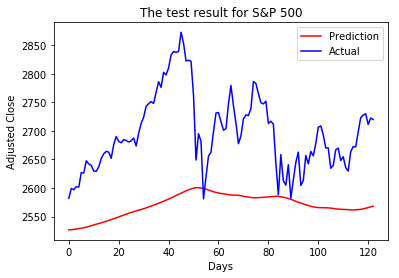

In [230]:
df1 = pd.read_csv('D:/data/sp500.csv', index_col = 'Date')
plot_result(df1, p, y_test)

**The reason for poor prediction may be the insufficiency of data.  
Now using all sp500 data**

In [147]:
df = pd.read_csv('D:/data/sp500-max.csv', index_col = 'Date')
df.drop(['Volume', 'Close'], 1, inplace = True)
df.index = pd.to_datetime(df.index)
df.head()

,Open,High,Low,Adj Close
Date,,,,
1950-01-03,16.66,16.66,16.66,16.66
1950-01-04,16.85,16.85,16.85,16.85
1950-01-05,16.93,16.93,16.93,16.93
1950-01-06,16.98,16.98,16.98,16.98
1950-01-09,17.08,17.08,17.08,17.08


In [148]:
min_max_scaler = preprocessing.MinMaxScaler()
df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
df['Adj Close']=min_max_scaler.fit_transform(
    df['Adj Close'].values.reshape(-1,1))

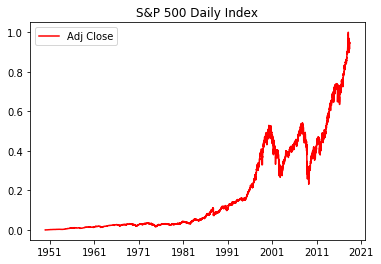

,Open,High,Low,Adj Close
Date,,,,
1950-01-03,0.000000,0.000000,0.000000,0.000000
1950-01-04,0.000067,0.000067,0.000067,0.000067
1950-01-05,0.000095,0.000095,0.000095,0.000095
1950-01-06,0.000112,0.000112,0.000113,0.000112
1950-01-09,0.000147,0.000147,0.000148,0.000147


In [161]:
plt.plot(df['Adj Close'], color = 'red', label = 'Adj Close')
plt.legend(loc = 'best')
plt.title('S&P 500 Daily Index')
plt.show()
df.head()

In [153]:
seq_len = 25
d = 0.1
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]

In [154]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [155]:
X_train.shape

(15462, 25, 4)

In [156]:
model = build_model2(shape, neurons, d)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 25, 128)           68096     
_________________________________________________________________
dropout_13 (Dropout)         (None, 25, 128)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [157]:
model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=300,
    validation_split=0.2,
    verbose=2)

Train on 12369 samples, validate on 3093 samples
Epoch 1/300
 - 24s - loss: 0.0026 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 2/300
 - 23s - loss: 6.4799e-05 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 3/300
 - 21s - loss: 5.2456e-05 - acc: 0.0000e+00 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 4/300
 - 23s - loss: 4.7758e-05 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 5/300
 - 24s - loss: 4.5466e-05 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 6/300
 - 23s - loss: 4.4692e-05 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 7/300
 - 21s - loss: 4.3012e-05 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 8/300
 - 21s - loss: 3.9656e-05 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 9/300
 - 21s - loss: 4.0504e-05 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 10/300
 - 21s - loss: 3.9816e-05 - acc: 0.0000e+00 - val_loss: 0.0012 - val_

Epoch 82/300
 - 21s - loss: 2.6626e-05 - acc: 0.0000e+00 - val_loss: 6.4062e-04 - val_acc: 0.0000e+00
Epoch 83/300
 - 21s - loss: 2.6753e-05 - acc: 0.0000e+00 - val_loss: 6.2163e-04 - val_acc: 0.0000e+00
Epoch 84/300
 - 21s - loss: 2.6471e-05 - acc: 0.0000e+00 - val_loss: 6.4242e-04 - val_acc: 0.0000e+00
Epoch 85/300
 - 21s - loss: 2.6479e-05 - acc: 0.0000e+00 - val_loss: 6.3395e-04 - val_acc: 0.0000e+00
Epoch 86/300
 - 21s - loss: 2.7243e-05 - acc: 0.0000e+00 - val_loss: 6.2602e-04 - val_acc: 0.0000e+00
Epoch 87/300
 - 26s - loss: 2.5929e-05 - acc: 0.0000e+00 - val_loss: 6.1754e-04 - val_acc: 0.0000e+00
Epoch 88/300
 - 30s - loss: 2.7499e-05 - acc: 0.0000e+00 - val_loss: 6.1320e-04 - val_acc: 0.0000e+00
Epoch 89/300
 - 29s - loss: 2.6789e-05 - acc: 0.0000e+00 - val_loss: 6.2101e-04 - val_acc: 0.0000e+00
Epoch 90/300
 - 27s - loss: 2.5815e-05 - acc: 0.0000e+00 - val_loss: 6.2154e-04 - val_acc: 0.0000e+00
Epoch 91/300
 - 22s - loss: 2.5862e-05 - acc: 0.0000e+00 - val_loss: 6.2515e-04 - 

Epoch 162/300
 - 28s - loss: 2.4468e-05 - acc: 0.0000e+00 - val_loss: 5.0568e-04 - val_acc: 0.0000e+00
Epoch 163/300
 - 23s - loss: 2.4193e-05 - acc: 0.0000e+00 - val_loss: 5.0890e-04 - val_acc: 0.0000e+00
Epoch 164/300
 - 21s - loss: 2.5820e-05 - acc: 0.0000e+00 - val_loss: 4.9544e-04 - val_acc: 0.0000e+00
Epoch 165/300
 - 21s - loss: 2.4331e-05 - acc: 0.0000e+00 - val_loss: 5.0445e-04 - val_acc: 0.0000e+00
Epoch 166/300
 - 21s - loss: 2.4073e-05 - acc: 0.0000e+00 - val_loss: 4.9654e-04 - val_acc: 0.0000e+00
Epoch 167/300
 - 20s - loss: 2.4754e-05 - acc: 0.0000e+00 - val_loss: 4.8228e-04 - val_acc: 0.0000e+00
Epoch 168/300
 - 21s - loss: 2.4125e-05 - acc: 0.0000e+00 - val_loss: 4.9634e-04 - val_acc: 0.0000e+00
Epoch 169/300
 - 21s - loss: 2.4881e-05 - acc: 0.0000e+00 - val_loss: 5.0152e-04 - val_acc: 0.0000e+00
Epoch 170/300
 - 22s - loss: 2.4773e-05 - acc: 0.0000e+00 - val_loss: 5.0093e-04 - val_acc: 0.0000e+00
Epoch 171/300
 - 23s - loss: 2.4836e-05 - acc: 0.0000e+00 - val_loss: 5.0

Epoch 242/300
 - 30s - loss: 2.3058e-05 - acc: 0.0000e+00 - val_loss: 4.6328e-04 - val_acc: 0.0000e+00
Epoch 243/300
 - 26s - loss: 2.5019e-05 - acc: 0.0000e+00 - val_loss: 4.5993e-04 - val_acc: 0.0000e+00
Epoch 244/300
 - 22s - loss: 2.3576e-05 - acc: 0.0000e+00 - val_loss: 4.5079e-04 - val_acc: 0.0000e+00
Epoch 245/300
 - 21s - loss: 2.2386e-05 - acc: 0.0000e+00 - val_loss: 4.5938e-04 - val_acc: 0.0000e+00
Epoch 246/300
 - 21s - loss: 2.2645e-05 - acc: 0.0000e+00 - val_loss: 4.6083e-04 - val_acc: 0.0000e+00
Epoch 247/300
 - 21s - loss: 2.2803e-05 - acc: 0.0000e+00 - val_loss: 4.5349e-04 - val_acc: 0.0000e+00
Epoch 248/300
 - 21s - loss: 2.2281e-05 - acc: 0.0000e+00 - val_loss: 4.5929e-04 - val_acc: 0.0000e+00
Epoch 249/300
 - 22s - loss: 2.2766e-05 - acc: 0.0000e+00 - val_loss: 4.5715e-04 - val_acc: 0.0000e+00
Epoch 250/300
 - 23s - loss: 2.3171e-05 - acc: 0.0000e+00 - val_loss: 4.5540e-04 - val_acc: 0.0000e+00
Epoch 251/300
 - 25s - loss: 2.3922e-05 - acc: 0.0000e+00 - val_loss: 4.5

In [158]:
score = model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00009 MSE (0.01 RMSE)
Test Score: 0.02838 MSE (0.17 RMSE)


In [159]:
(p,percentage_diff) = percentage_difference(model, X_test, y_test)

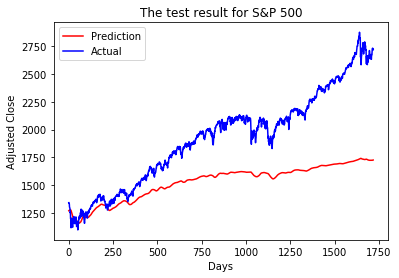

In [160]:
df1 = pd.read_csv('D:/data/sp500-max.csv', index_col = 'Date')
plot_result(df1, p, y_test)

**Hypertunning and further development is needed**  
This model is truely expensive when huge amount of data is added. It took 2 hours to train and it would take much more time to tune and to refine it.